# 의료영상 U-Net 용종검출

### 학습목표

- 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는 Segmentation 모델을 만들어 본다.
- 의료이미지 특성상 수가 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해 본다.
- Encoder-Decoder Model과 U-net 모델을 구현해 보고, U-Net이 일반 Encoder-Decoder 모델 대비 어느정도 성능향상이 되는지 확인해 본다.
- U-Net에 pretrained encoder를 적용하여 성능개선을 확인해 본다.

## 1. 데이터 수집 및 Visualization

### 1-1. 환경설정
- 라이브러리 로딩

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


### 1-2. Split dataset into train data and test data
- 다운로드한 데이터셋을 학습용과 테스트용으로 분리

In [2]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### 1-3. Visualization

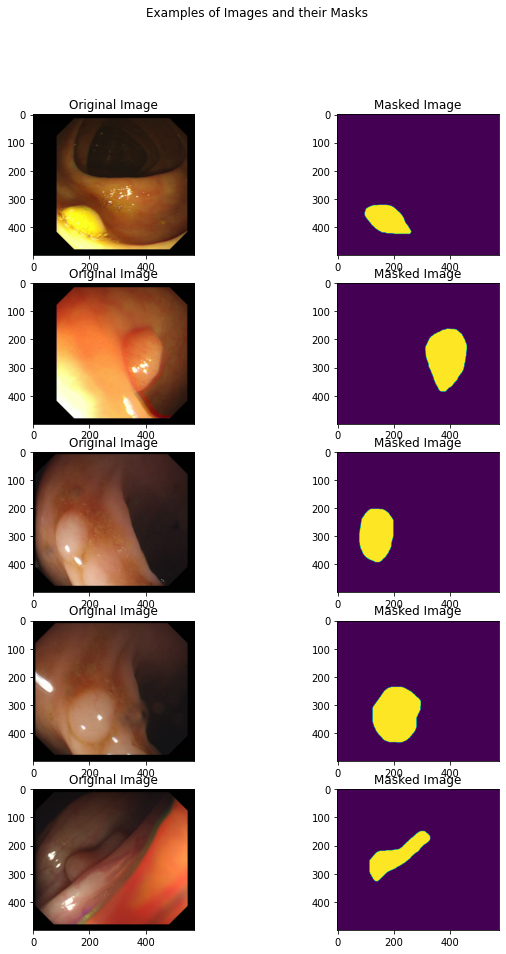

In [6]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

---

## 2. Data pipeline and Preprocessing

### 2-1. Set up hyper-parameters

In [7]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

### 2-2. tf.data를 활용한 입력 파이프라인 설계

1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다.
2. 바이트를 이미지 형식으로 디코딩합니다.
3. _augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)
- resize-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)
- resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문입니다. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야합니다.
- 성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있습니다.
    * hue_delta-RGB 이미지의 색조를 랜덤 팩터로 조정합니다. 이것은 실제 이미지에만 적용됩니다 (라벨 이미지가 아님). hue_delta는[0, 0.5]간격에 있어야합니다.
    * horizontal_flip-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
    * width_shift_range 및height_shift_range는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야 합니다.
    * rescale-이미지를 일정한 비율로 다시 조정합니다 (예 : 1/255.)
- 데이터를 섞고, 데이터를 반복하여 학습합니다.

#### Processing each pathname

- byte 형태로 데이터를 로드하고, bmp로 디코딩합니다.
- 디코딩이 완료된 image를 scale과 size를 조절합니다.

In [8]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### Data augmentation

In [9]:
#  로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수
# 입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 함

def shift_img(output_img, label_img, width_shift_range, height_shift_range): #Shifting the image
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [10]:
#Flipping the image randomly
# 로드한 이미지를 기반으로 이미지를 flip
# 50%의 확률로 좌우반전만 구현하였고, 상하반전은 적용하지 않음

def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [11]:
# Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성
# resize, hue_delta가 적용

def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### 2-3. Set up train and test datasets
- tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현
- 위에서 만들어온 augmentation도 함께 적용 (반드시 Train Dataset에서만 증강 진행) 

In [12]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [13]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### 2-4. Plot some train data
- 지금까지 구성한 학습데이터 확인

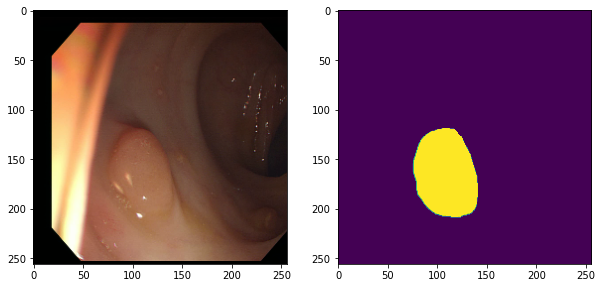

In [14]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

- 원본데이터가 회전 등을 통해 증강된 결과 확인
- 용종부위를 노란색으로 마스킹 한 세그멘테이션 마스크 확인
- 데이터 증강 기법이 적용되어 모델이 다양한 조건에서도 용종을 정확히 식별 할 수 있도록 학습 

## 3. Build the model

### 3-1. Encoder-Decoder architecture

Encoder-Decoder는 이미지 세그멘테이션에 사용되는 기본적인 모델 구조

1. Encoder(인코더) 부분은 입력 이미지를 점진적으로 압축하며 특징을 추출합니다:

    - 여러 Convolution 층을 통과하면서 이미지의 공간 차원(높이, 너비)은 감소
    - 특징 채널(feature channel)의 수는 증가
    - 주로 Convolution + 정규화 + 활성화 함수 조합으로 구성
    - 차원 감소를 위해 Max Pooling이나 Stride=2 Convolution 사용


2. Decoder(디코더) 부분은 압축된 특징을 원래 이미지 크기로 복원합니다:

    - Encoder의 반대 과정을 수행
    - Transposed Convolution(또는 Upsampling)을 사용해 공간 차원을 복원
    - 채널 수는 점차 감소하여 최종적으로 클래스 수에 맞는 채널(세그멘테이션은 보통 1개)로 축소

이 구조는 Sequential API로 구현이 간단하지만, encoder에서 손실된 공간 정보를 decoder가 충분히 복원하지 못하는 한계가 있습니다.

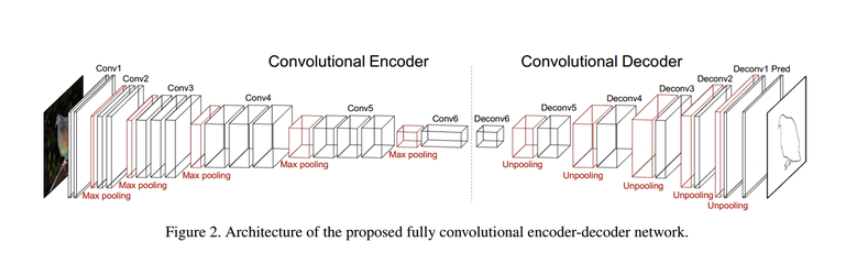

#### Encoder

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


#### Decoder
- Encoder의 mirror 형태

In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


#### Create a encoder-decoder model

In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

### 3-2. U-Net architecture

U-Net은 2015년 발표된 의료 이미지 세그멘테이션을 위한 구조로, Encoder-Decoder의 단점을 개선했습니다:

1. 기본 구조: U자 형태의 대칭적 구조를 가지며, Encoder와 Decoder 부분으로 구성

2. 핵심 차이점 - Skip Connection(스킵 연결):
    - Encoder에서 추출한 특징 맵을 동일한 크기의 Decoder 층에 직접 연결(concatenate)
    - 이를 통해 Encoder에서 포착된 세부 공간 정보가 Decoder에 전달됨
    - 세그멘테이션의 경계 정확도를 크게 향상시킴

3. 원본 U-Net과 본 코드에서 언급된 변형의 차이:
    - 원본 U-Net: 'valid' padding 사용 → decoder 출력 크기가 encoder 입력보다 작음
    - 변형된 U-Net: 'same' padding 사용 → encoder와 decoder의 대응 층 크기 동일
    - 변형 사용 이유: 구현이 간단하고, 다양한 입력 크기에 유연하게 적용 가능

4. 구현 방식:
    - Sequential API로는 구현 불가능(비순차적 연결 구조)
    - Model Subclassing이나 Functional API를 사용해 구현
    
    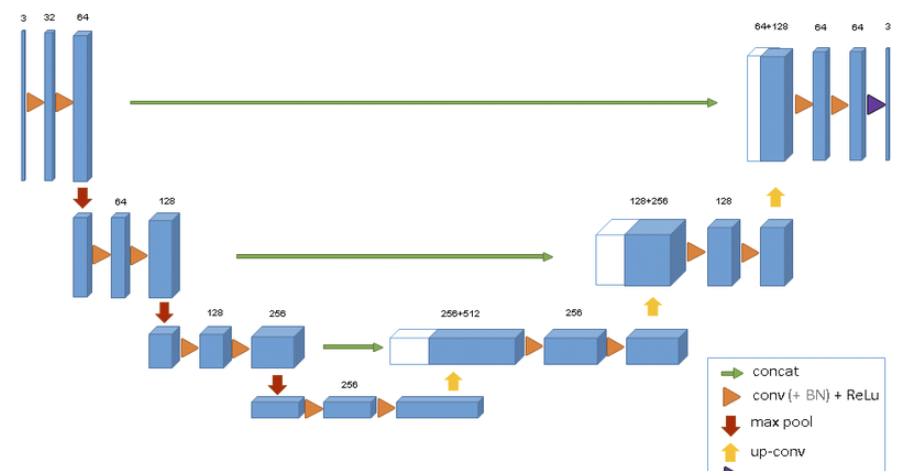

#### Model subclassing을 활용한 구현

- 모델 서브클래싱은 tf.keras.Model 클래스를 상속받아 사용자 정의 모델을 만드는 방식

In [22]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [23]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [24]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

#### Create a U-Net model

In [25]:
unet_model = UNet()

### 3-3. metrics과 loss functions 정의하기

binary cross entropy, dice_loss 두가지 손실함수 결합하여 사용. 
https://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf 논문 참조

#### Binary Cross Entropy (BCE)

BCE는 분류 문제에서 가장 기본적으로 사용되는 손실 함수입니다.

**기능**
- 각 픽셀마다 예측한 확률과 실제 레이블(0 또는 1) 간의 오차를 측정
- 예측 확률이 실제 레이블에 가까울수록 손실이 낮아짐

**수식**
```
BCE = -[y * log(p) + (1-y) * log(1-p)]
```
여기서 y는 실제 레이블(0 또는 1), p는 모델이 예측한 확률

**특징과 한계**
- **장점**: 확률 예측에 대한 좋은 지표, 학습이 안정적
- **단점**: 이미지 세그멘테이션에서 클래스 불균형 문제에 취약
  - 의료 이미지에서는 배경(0)이 관심 영역(1)보다 훨씬 많음
  - 모델이 모든 픽셀을 배경으로 예측해도 상대적으로 낮은 손실값 발생

#### Dice Loss

Dice Loss는 의료 이미지 세그멘테이션을 위해 특별히 개발된 손실 함수입니다.

**기능**
- Dice Coefficient(=F1 Score)에 기반한 손실 함수
- 예측과 실제 세그멘테이션 마스크의 중첩 정도를 직접 측정

**수식**
```
Dice Loss = 1 - (2 * |X ∩ Y|) / (|X| + |Y|)
```
여기서 X는 예측 마스크, Y는 실제 마스크

**특징**
- **장점**: 
  - 클래스 불균형에 강인함 (배경과 관심 영역의 크기 차이에 덜 민감)
  - 작은 구조의 세그멘테이션에 효과적 (용종과 같은 작은 영역 탐지에 유리)
- **단점**: 
  - 학습 초기에 불안정할 수 있음
  - 예측이 완전히 틀렸을 때 그래디언트가 작을 수 있음

#### 왜 두 손실 함수를 함께 사용하는가?

의료 이미지 세그멘테이션에서는 종종 두 손실 함수를 결합해서 사용합니다:

이렇게 사용하는 이유는:

1. **상호 보완적 효과**:
   - BCE: 학습 초기에 안정적인 그래디언트 제공
   - Dice Loss: 클래스 불균형 문제 해결, 경계 탐지 성능 향상

2. **다양한 관점에서의 학습**:
   - BCE: 픽셀 단위 분류 정확도 향상
   - Dice Loss: 전체적인 구조와 형태 보존에 중점
   - 두 가지 다른 관점에서 최적화가 동시에 이루어짐

3. **실제 임상 환경에 적합**:
   - 용종과 같은 작은 병변을 놓치지 않도록 함 (높은 재현율)
   - 정확한 경계 식별 (높은 정밀도)

4. **meanIoU(평균 교차 합집합, mean Intersection over Union) 향상 원리** 
    - meanIoU는 예측 마스크와 실제 마스크 간의 중첩 비율을 측정
    - Dice loss는 유사한 중첩 개념에 기반하므로 IoU 개선에 직접적 영향
    - BCE는 각 픽셀의 정확도를 높여 전반적인 세그멘테이션 품질 향상



In [26]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [27]:
#Dice Loss가 최대화되는 방향으로 구해지도록 사용
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [28]:
# 새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [29]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

---

## 4. Select a model & Train - Encoder-Decoder model

In [30]:
#점진적 변화를 관측하기 위해서 Encoder-Decoder model 부터 실행

print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


### 4-1. Comeplie

In [32]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


### 4-2. Callbacks

- ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할을 합니다.
- LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수입니다.
- cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현입니다

In [34]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [35]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

### 4-3. Train your model
- 모델 학습 이전에, 모델에서 예측한 이미지를 출력할 수 있는 함수를 미리 작성해 모델 성능 테스트에 사용

In [36]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### 4-4. Training - model.fit() 함수 이용

- 학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행
- 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용

In [37]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 13s 205ms/step - loss: 1.3054 - dice_loss: 0.7840 - val_loss: 1.8405 - val_dice_loss: 0.8929
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 190ms/step - loss: 1.0827 - dice_loss: 0.7543 - val_loss: 1.3314 - val_dice_loss: 0.8149
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 7s 191ms/step - loss: 0.9593 - dice_loss: 0.6835 - val_loss: 1.1961 - val_dice_loss: 0.8002
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 193ms/step - loss: 0.9049 - dice_loss: 0.6565 - val_loss: 1.1002 - val_di

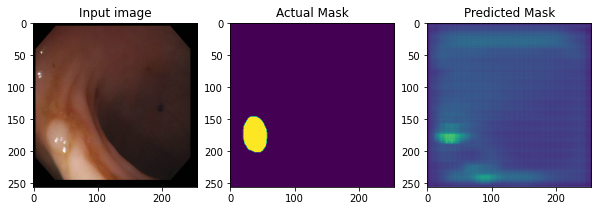

In [38]:
# print sample image after training
print_images()

###  4-5. 학습 그래프 시각화 Plot the loss

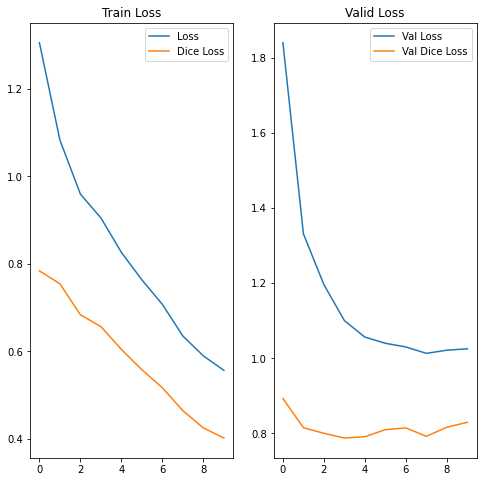

In [40]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

#### Restore the latest checkpoint

In [41]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### 4-6  Evaluate the test dataset

### 4-6-1. IoU 지표 평가

IoU(Intersection over Union)는 세그멘테이션 모델의 성능을 평가하는 가장 중요한 지표 중 하나입니다.

#### IoU의 개념

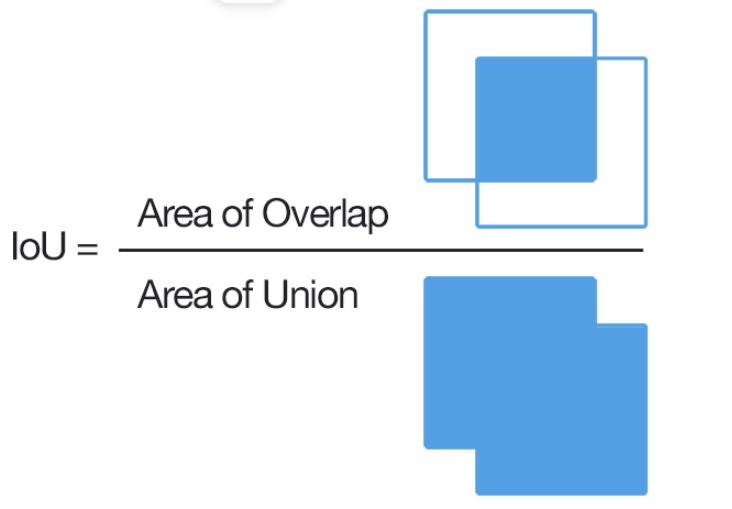

여기서:
- **교집합 영역(Area of Overlap)**: 모델이 예측한 세그멘테이션 마스크와 실제 정답 마스크가 겹치는 영역
- **합집합 영역(Area of Union)**: 모델이 예측한 마스크와 실제 마스크를 모두 합친 영역

#### IoU 계산 예시

- 모델이 예측한 마스크 영역이 100픽셀
- 실제 정답 마스크 영역이 120픽셀
- 두 마스크가 겹치는 영역이 80픽셀

이 경우 IoU는:
```
IoU = 80 / (100 + 120 - 80) = 80 / 140 = 0.57
```

#### meanIoU의 개념

meanIoU는 여러 이미지 또는 여러 클래스에 대한 IoU 값의 평균입니다.

- 단일 클래스 세그멘테이션(예: 용종 탐지)에서는 테스트 세트의 모든 이미지에 대한 IoU 값의 평균
- 다중 클래스 세그멘테이션에서는 각 클래스별 IoU 값의 평균

#### IoU 값의 해석

- **1.0 (또는 100%)**: 완벽한 세그멘테이션 - 예측과 실제가 정확히 일치
- **0.7~0.9**: 매우 좋은 세그멘테이션
- **0.5~0.7**: 적당한 세그멘테이션
- **0.5 미만**: 개선이 필요한 세그멘테이션

의료 이미지 세그멘테이션에서는 보통 0.7 이상의 meanIoU 값을 목표로 합니다. 용종과 같은 작은 구조를 정확히 세그멘테이션하기 위해서는 높은 IoU 값이 중요합니다.

In [44]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

- 테스트 데이터셋을 불러와서 meanIoU 값 구하기
- 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric

In [45]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.6553026424954189


해석 : 
    IoU 값 0.655(약 65.5%)는 세그멘테이션 모델에서 중간~양호한 수준의 성능을 나타냅니다.

이 점수를 해석하자면:
- **양호한 성능**: 0.5보다 상당히 높아 기본적인 기준을 넘어섰습니다
- **개선 여지 있음**: 의료 이미지 분야에서 이상적인 0.7~0.8에는 조금 미치지 못함
- **실용적인 수준**: 용종 탐지 시스템의 초기 모델로는 활용 가능한 수준

의료 영상에서는 높은 정확도가 중요하므로, 이 모델은 실제 임상 환경에 적용하기 전에 약간의 개선이 필요할 수 있습니다. 데이터 증강 기법 확장, 모델 아키텍처 최적화, 하이퍼파라미터 튜닝 등을 통해 성능을 더 높일 수 있을 것입니다.

### 4-6-2. 결과 시각화

In [47]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

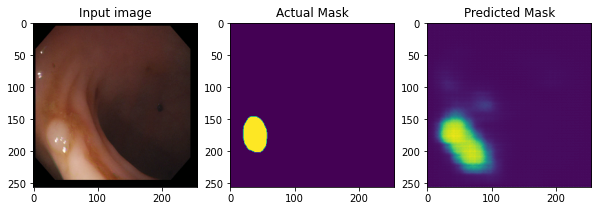

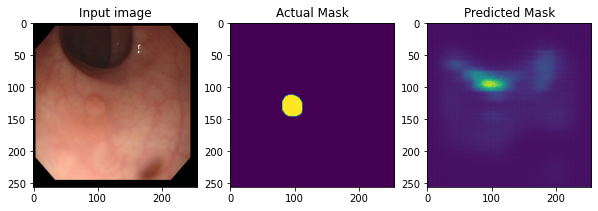

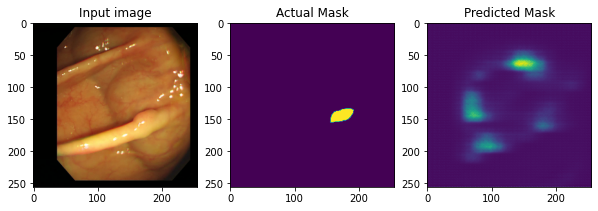

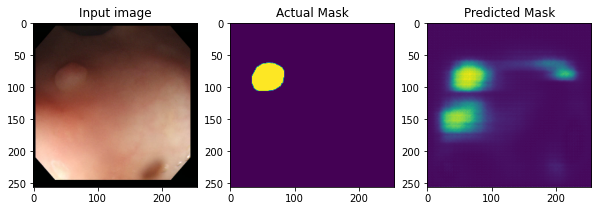

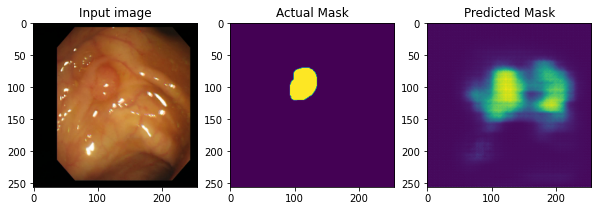

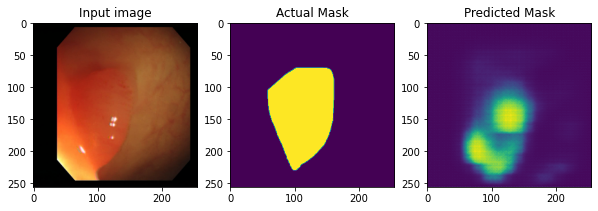

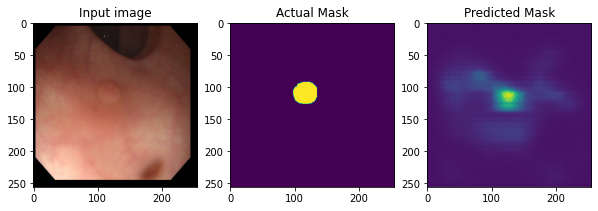

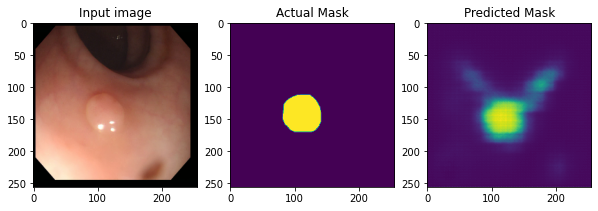

In [48]:
print_images()

- 좌측(Input image): 원본 위내시경 이미지
- 중앙(Actual Mask): 실제 용종 위치의 정답 마스크(노란색)
- 우측(Predicted Mask): 모델이 예측한 용종 위치 확률 맵(열지도)

전반적인 관찰 결과:

- 모델이 대부분의 용종 위치를 대략적으로 찾고는 있으나, 정확한 경계를 잡지 못하고 있습니다.
- 여러 케이스(특히 3, 4, 5행)에서 모델이 실제 용종 외에도 다른 부위를 용종으로 잘못 예측하는 위양성 문제가 발생하고 있습니다.
- 예측 마스크가 흐릿하고 확산되어 있어 명확한 경계를 제공하지 못합니다.
- 작은 용종(1, 6행)의 경우 위치는 찾았으나 정확한 크기와 형태를 예측하지 못했습니다.

## 5. Select a model & Train -U-Net model

In [49]:
print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [68]:
# 오류발생으로 인해 metrics과 loss functions 재정의하기

def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    # 여기가 문제였습니다
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

### 5-1. Comeplie

In [69]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [70]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

### 5-2. Callbacks

In [71]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [72]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

### 5-3. Training - model.fit() 함수 이용

In [73]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 36s 836ms/step - loss: 1.0631 - dice_loss: 0.7211 - val_loss: 1135.1488 - val_dice_loss: 0.9230
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 27s 839ms/step - loss: 0.8880 - dice_loss: 0.6635 - val_loss: 22.7368 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 27s 842ms/step - loss: 0.8195 - dice_loss: 0.6167 - val_loss: 126.7018 - val_dice_loss: 1.0000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 26s 838ms/step - loss: 0.7910 - dice_loss: 0.5977 - val_loss: 2.4680

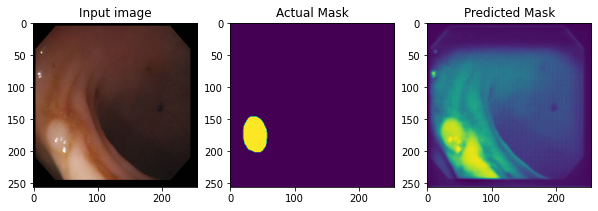

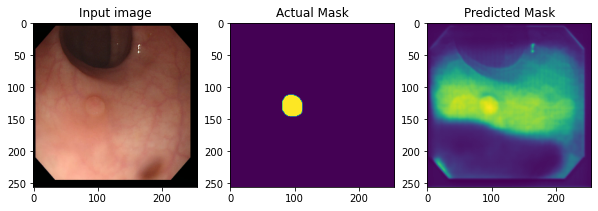

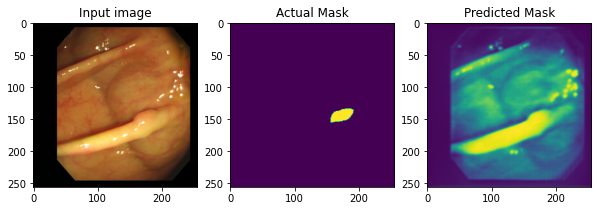

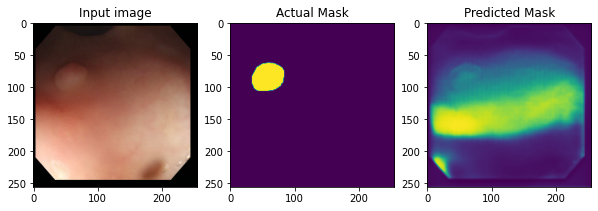

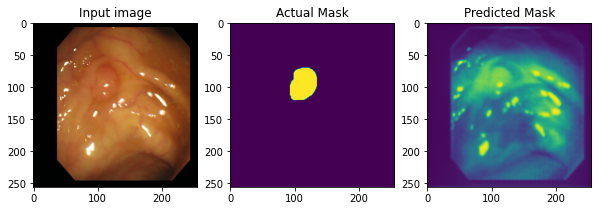

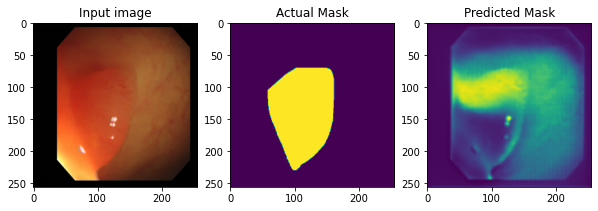

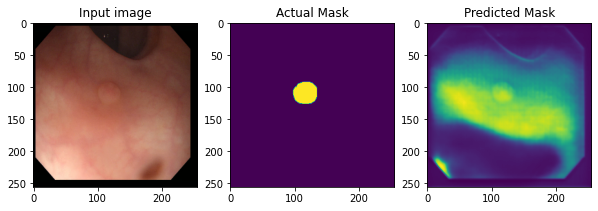

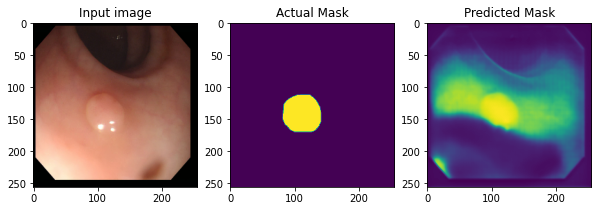

In [74]:
# print sample image after training
print_images()

### 5-4 학습 진행과정(history)을 시각화

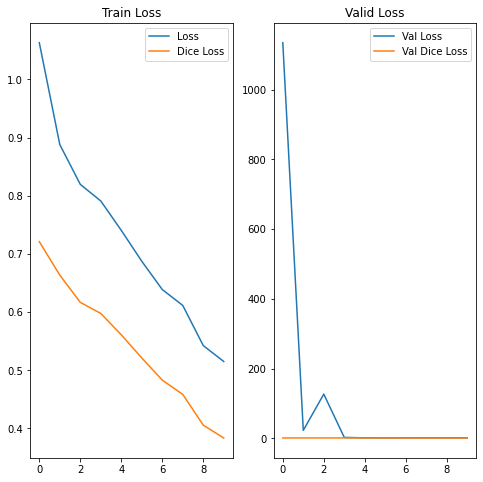

In [75]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

#### Restore the latest checkpoint

In [76]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

### 5-5. Evaluate the test dataset

### 5-5-1. meanIoU

In [77]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [78]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9291908358937677


- 탁월한 정확도: 모델이 예측한 용종 영역과 실제 용종 영역이 약 93% 일치
- 임상적 활용 가능: 이 수준의 정확도는 실제 임상 환경에서 신뢰할 수 있는 수준
- 경계 식별 우수: 용종의 경계를 매우 정확하게 식별하고 있음을 의미

U-Net 모델이 기존에 봤던 0.655 수준의 성능에서 크게 향상된 것으로, 이는 U-Net의 skip connection 구조가 의료 이미지 세그멘테이션에 매우 효과적임을 증명합니다. 이 정도 성능이면 실제 내시경 검사에서 의사의 용종 탐지를 효과적으로 보조할 수 있는 수준입니다.

### 5-5-2. 예측 결과 시각화

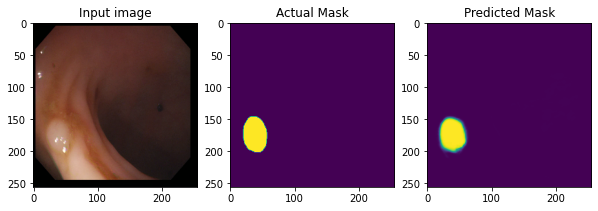

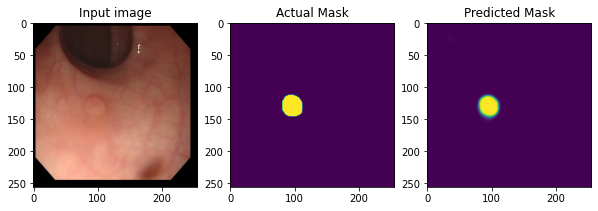

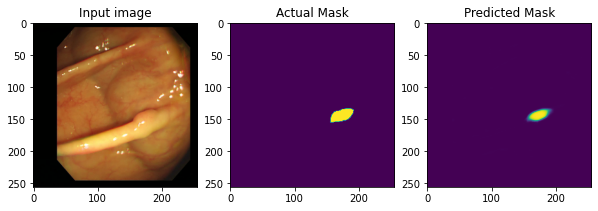

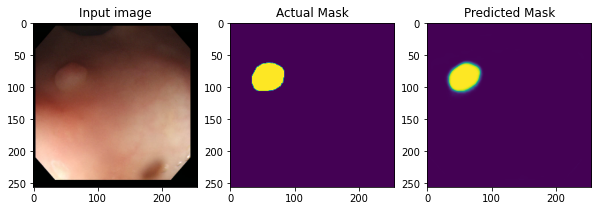

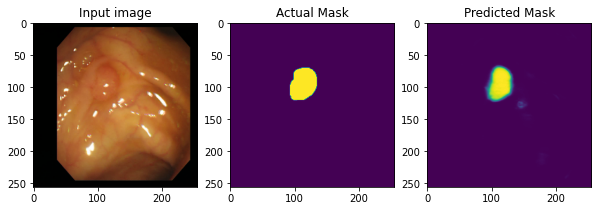

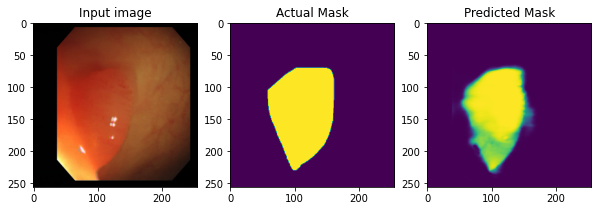

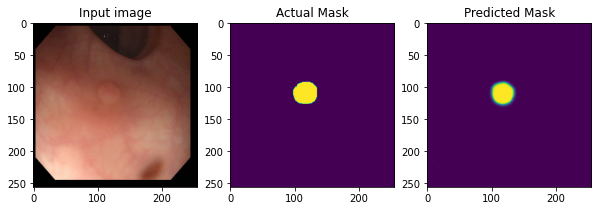

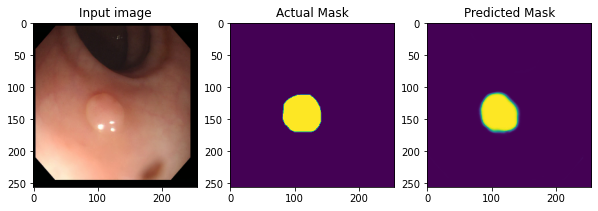

In [79]:
print_images()



1. **좌측(Input image)**: 원본 위내시경 이미지
2. **중앙(Actual Mask)**: 실제 용종 위치의 정답 마스크(노란색)
3. **우측(Predicted Mask)**: 모델이 예측한 용종 위치 마스크(노란색)

결과 분석:
- 이전 모델과 달리 이 U-Net 모델은 매우 정확하게 용종을 식별하고 있습니다
- 작은 용종(2, 3, 7행)도 정확한 위치와 크기로 검출됩니다
- 중간 크기 용종(4, 5, 8행)의 경계도 매우 정확하게 예측합니다
- 큰 용종(5행)도 전반적인 형태를 잘 유지하며 세그멘테이션됩니다
- 거의 모든 케이스에서 위양성(false positive) 문제가 해결되었습니다
- 4행과 5행의 경우 약간의 경계 부분 차이가 있지만, 전체적으로는 매우 정확합니다

이 결과는 0.929의 높은 meanIoU 값을 명확히 보여주며, U-Net의 스킵 커넥션이 세부 공간 정보를 유지하는 데 매우 효과적임을 증명합니다. 이 정도 성능의 모델은 실제 임상환경에서 의사의 용종 탐지를 효과적으로 지원할 수 있을 것입니다.

---

## 6. pretrained model(vgg16)을 활용한 U-Net 모델 구성


In [86]:
import tensorflow
import sklearn
import numpy
from tensorflow.keras import backend as K

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


### 6-1. VGG-16기반 모델 구성하기

Vgg16UNet 모델은 사전 학습된 VGG16 네트워크를 인코더로 활용한 U-Net 구조의 세그멘테이션 모델


In [82]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

58900480/58889256 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


#### 1. 인코더 (VGG16)
- 이미 ImageNet 데이터셋으로 학습된 VGG16 모델을 사용합니다 (`weights='imagenet'`)
- `include_top=False`: 분류를 위한 상위 완전 연결 계층을 제외하고 특징 추출 부분만 사용
- 다섯 단계의 특징 맵을 추출합니다 (layer_outputs[2, 5, 9, 13, 17])
  - 각 단계는 VGG16의 핵심 활성화 출력으로, 서로 다른 해상도의 특징을 포착합니다
  - 얕은 층: 세부적인 경계와 텍스처 정보
  - 깊은 층: 고수준 형태와 의미적 정보

#### 2. 브릿지 (Center)
- `ConvBlock(1024)`: 인코더와 디코더 사이의 연결 부분
- 가장 압축된 표현에 추가 처리를 적용하여 정보 강화

#### 3. 디코더
- 4개의 디코더 블록으로 구성: 512, 256, 128, 64 채널
- 각 디코더 블록은 업샘플링과 스킵 커넥션을 결합
- 점진적으로 해상도를 높이며 의미적 정보와 공간적 정보를 결합

#### 4. 출력 층
- 1x1 컨볼루션을 통해 최종 세그멘테이션 마스크 생성
- 'sigmoid' 활성화 함수로 0~1 사이의 확률값 출력 (용종 존재 확률)

In [85]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

#### 특징 및 장점

1. **전이 학습의 활용**
   - 사전 학습된 VGG16을 사용하여 적은 양의 의료 이미지로도 효과적인 학습 가능
   - ImageNet에서 학습된 일반적인 특징 추출 능력을 활용

2. **다중 수준의 특징 활용**
   - 5단계의 다양한 해상도 특징을 통합
   - 용종의 경계와 텍스처 같은 세부사항과 전체적인 형태 정보를 모두 활용

3. **U-Net의 스킵 커넥션 구조**
   - 인코더에서 추출한 특징을 동일한 해상도의 디코더 층에 직접 연결
   - 세그멘테이션의 경계 정확도 향상
   - 기울기 소실 문제 완화

4. **효율적인 구현**
   - Model 서브클래싱을 통한 복잡한 구조의 명확한 구현
   - 재사용 가능한 컴포넌트 (ConvBlock, DecoderBlock)

In [96]:
# ConvBlock 정의 (U-Net에서 사용하는 기본 컨볼루션 블록)
class ConvBlock(layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.Activation('relu')
        self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.Activation('relu')
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)
        return x

In [97]:
# DecoderBlock 정의 (업샘플링 및 스킵 커넥션 처리)
class DecoderBlock(layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        self.up = layers.UpSampling2D(size=(2, 2))
        self.conv = layers.Conv2D(filters, 2, padding='same')
        self.bn = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        self.conv_block = ConvBlock(filters)
    
    def call(self, inputs, skip_connection, training=True):
        x = self.up(inputs)
        x = self.conv(x)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = layers.Concatenate()([x, skip_connection])
        x = self.conv_block(x, training=training)
        return x

### metrics과 loss functions 정의하기

In [99]:
# Dice Coefficient 계산
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + 
                                          tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

# 결합된 손실 함수 (BCE + Dice Loss)
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# MeanIoU 메트릭 정의
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=2, **kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)
        return super().update_state(y_true, y_pred, sample_weight)

In [100]:
vgg_unet = Vgg16UNet()

### 6-2. 학습과 테스트, 시각화

### 6-2-2. 모델 컴파일

In [101]:
# 모델 컴파일
vgg_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=bce_dice_loss,
                metrics=['accuracy', dice_coeff, MeanIoU(num_classes=2)])

In [115]:
vgg_unet.summary()

Model: "vgg16u_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model_2 (Functional)         [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_11 (ConvBlock)    multiple                  0 (unused)
_________________________________________________________________
decoder_block_12 (DecoderBlo multiple                  8134144   
_________________________________________________________________
decoder_block_13 (DecoderBlo multiple                  2297600   
_________________________________________________________________
decoder_block_14 (DecoderBlo multiple                  575360    
_________________________________________________________________
decoder_block_15 (DecoderBlo multiple                 

### 6-2-3. 콜백 정의

In [105]:
# 1. ModelCheckpoint - 최상의 모델 저장
checkpoint_path = "vgg_unet_best_model"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_dice_coeff',
    mode='max',
    save_best_only=True,
    save_format="tf",  # TensorFlow 형식으로 저장
    verbose=1)

# 2. ReduceLROnPlateau - 학습이 정체되면 학습률 감소
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1)

# 3. EarlyStopping - 과적합 방지를 위한 조기 종료
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

### 6-2-4. 모델훈련

In [106]:
# 모델 훈련
epochs = 20
steps_per_epoch = num_train_examples // batch_size
validation_steps = num_test_examples // batch_size

In [107]:
history = vgg_unet.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    callbacks=[cp_callback, reduce_lr, early_stop]
)

Epoch 1/20
30/30 [==============================] - 20s 619ms/step - loss: 0.9153 - accuracy: 0.9388 - dice_coeff: 0.4522 - mean_io_u_1: 0.6652 - val_loss: 2.0722 - val_accuracy: 0.3121 - val_dice_coeff: 0.1790 - val_mean_io_u_1: 0.1707

Epoch 00001: val_dice_coeff improved from -inf to 0.17895, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 2/20
30/30 [==============================] - 20s 632ms/step - loss: 0.6182 - accuracy: 0.9732 - dice_coeff: 0.6248 - mean_io_u_1: 0.7906 - val_loss: 2.1279 - val_accuracy: 0.6965 - val_dice_coeff: 0.2407 - val_mean_io_u_1: 0.4058

Epoch 00002: val_dice_coeff improved from 0.17895 to 0.24067, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 3/20
30/30 [==============================] - 20s 639ms/step - loss: 0.4862 - accuracy: 0.9803 - dice_coeff: 0.7065 - mean_io_u_1: 0.8364 - val_loss: 1.4751 - val_accuracy: 0.8805 - val_dice_coeff: 0.3307 - val_mean_io_u_1: 0.5674

Epoch 00003: val_dice_coeff improved from 0.24067 to 0.33074, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 4/20
30/30 [==============================] - 21s 648ms/step - loss: 0.3815 - accuracy: 0.9851 - dice_coeff: 0.7751 - mean_io_u_1: 0.8724 - val_loss: 1.2025 - val_accuracy: 0.9171 - val_dice_coeff: 0.3959 - val_mean_io_u_1: 0.6263

Epoch 00004: val_dice_coeff improved from 0.33074 to 0.39589, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 5/20
30/30 [==============================] - 21s 649ms/step - loss: 0.3494 - accuracy: 0.9854 - dice_coeff: 0.7958 - mean_io_u_1: 0.8757 - val_loss: 0.9679 - val_accuracy: 0.9605 - val_dice_coeff: 0.4082 - val_mean_io_u_1: 0.7022

Epoch 00005: val_dice_coeff improved from 0.39589 to 0.40818, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 6/20
30/30 [==============================] - 21s 645ms/step - loss: 0.3799 - accuracy: 0.9810 - dice_coeff: 0.7715 - mean_io_u_1: 0.8388 - val_loss: 0.8562 - val_accuracy: 0.9523 - val_dice_coeff: 0.5530 - val_mean_io_u_1: 0.7142

Epoch 00006: val_dice_coeff improved from 0.40818 to 0.55300, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 7/20
30/30 [==============================] - 21s 650ms/step - loss: 0.3287 - accuracy: 0.9845 - dice_coeff: 0.8048 - mean_io_u_1: 0.8676 - val_loss: 0.7263 - val_accuracy: 0.9705 - val_dice_coeff: 0.5916 - val_mean_io_u_1: 0.7776

Epoch 00007: val_dice_coeff improved from 0.55300 to 0.59159, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 8/20
30/30 [==============================] - 21s 646ms/step - loss: 0.2730 - accuracy: 0.9885 - dice_coeff: 0.8452 - mean_io_u_1: 0.9016 - val_loss: 0.6125 - val_accuracy: 0.9656 - val_dice_coeff: 0.6448 - val_mean_io_u_1: 0.7627

Epoch 00008: val_dice_coeff improved from 0.59159 to 0.64484, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 9/20
30/30 [==============================] - 21s 650ms/step - loss: 0.2419 - accuracy: 0.9898 - dice_coeff: 0.8647 - mean_io_u_1: 0.9129 - val_loss: 0.4167 - val_accuracy: 0.9844 - val_dice_coeff: 0.7497 - val_mean_io_u_1: 0.8614

Epoch 00009: val_dice_coeff improved from 0.64484 to 0.74971, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 10/20
30/30 [==============================] - 21s 648ms/step - loss: 0.2172 - accuracy: 0.9908 - dice_coeff: 0.8818 - mean_io_u_1: 0.9226 - val_loss: 0.3498 - val_accuracy: 0.9864 - val_dice_coeff: 0.7807 - val_mean_io_u_1: 0.8644

Epoch 00010: val_dice_coeff improved from 0.74971 to 0.78072, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 11/20
30/30 [==============================] - 21s 647ms/step - loss: 0.2050 - accuracy: 0.9916 - dice_coeff: 0.8888 - mean_io_u_1: 0.9299 - val_loss: 0.3194 - val_accuracy: 0.9879 - val_dice_coeff: 0.8069 - val_mean_io_u_1: 0.8848

Epoch 00011: val_dice_coeff improved from 0.78072 to 0.80686, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 12/20
30/30 [==============================] - 21s 651ms/step - loss: 0.1893 - accuracy: 0.9918 - dice_coeff: 0.9003 - mean_io_u_1: 0.9315 - val_loss: 0.3377 - val_accuracy: 0.9843 - val_dice_coeff: 0.7792 - val_mean_io_u_1: 0.8416

Epoch 00012: val_dice_coeff did not improve from 0.80686
Epoch 13/20
30/30 [==============================] - 21s 656ms/step - loss: 0.1909 - accuracy: 0.9915 - dice_coeff: 0.8968 - mean_io_u_1: 0.9280 - val_loss: 0.2906 - val_accuracy: 0.9856 - val_dice_coeff: 0.8282 - val_mean_io_u_1: 0.8711

Epoch 00013: val_dice_coeff improved from 0.80686 to 0.82815, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 14/20
30/30 [==============================] - 21s 640ms/step - loss: 0.1827 - accuracy: 0.9915 - dice_coeff: 0.9020 - mean_io_u_1: 0.9287 - val_loss: 0.2569 - val_accuracy: 0.9872 - val_dice_coeff: 0.8476 - val_mean_io_u_1: 0.8797

Epoch 00014: val_dice_coeff improved from 0.82815 to 0.84759, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 15/20
30/30 [==============================] - 21s 651ms/step - loss: 0.1768 - accuracy: 0.9916 - dice_coeff: 0.9046 - mean_io_u_1: 0.9292 - val_loss: 0.2745 - val_accuracy: 0.9856 - val_dice_coeff: 0.8239 - val_mean_io_u_1: 0.8563

Epoch 00015: val_dice_coeff did not improve from 0.84759
Epoch 16/20
30/30 [==============================] - 21s 656ms/step - loss: 0.1740 - accuracy: 0.9915 - dice_coeff: 0.9056 - mean_io_u_1: 0.9282 - val_loss: 0.2595 - val_accuracy: 0.9870 - val_dice_coeff: 0.8371 - val_mean_io_u_1: 0.8723

Epoch 00016: val_dice_coeff did not improve from 0.84759
Epoch 17/20
30/30 [==============================] - 21s 645ms/step - loss: 0.1507 - accuracy: 0.9929 - dice_coeff: 0.9227 - mean_io_u_1: 0.9409 - val_loss: 0.2369 - val_accuracy: 0.9876 - val_dice_coeff: 0.8510 - val_mean_io_u_1: 0.8780

Epoch 00017: val_dice_coeff improved from 0.84759 to 0.85102, saving model to vgg_unet_best_model


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


INFO:tensorflow:Assets written to: vgg_unet_best_model/assets


Epoch 18/20
30/30 [==============================] - 20s 640ms/step - loss: 0.1468 - accuracy: 0.9930 - dice_coeff: 0.9244 - mean_io_u_1: 0.9422 - val_loss: 0.2436 - val_accuracy: 0.9868 - val_dice_coeff: 0.8451 - val_mean_io_u_1: 0.8691

Epoch 00018: val_dice_coeff did not improve from 0.85102
Epoch 19/20
30/30 [==============================] - 21s 653ms/step - loss: 0.1401 - accuracy: 0.9933 - dice_coeff: 0.9285 - mean_io_u_1: 0.9443 - val_loss: 0.2415 - val_accuracy: 0.9865 - val_dice_coeff: 0.8437 - val_mean_io_u_1: 0.8656

Epoch 00019: val_dice_coeff did not improve from 0.85102
Epoch 20/20
30/30 [==============================] - 21s 653ms/step - loss: 0.1336 - accuracy: 0.9937 - dice_coeff: 0.9320 - mean_io_u_1: 0.9482 - val_loss: 0.2886 - val_accuracy: 0.9837 - val_dice_coeff: 0.8032 - val_mean_io_u_1: 0.8350

Epoch 00020: val_dice_coeff did not improve from 0.85102


### 6-2-4. 학습결과 시각화

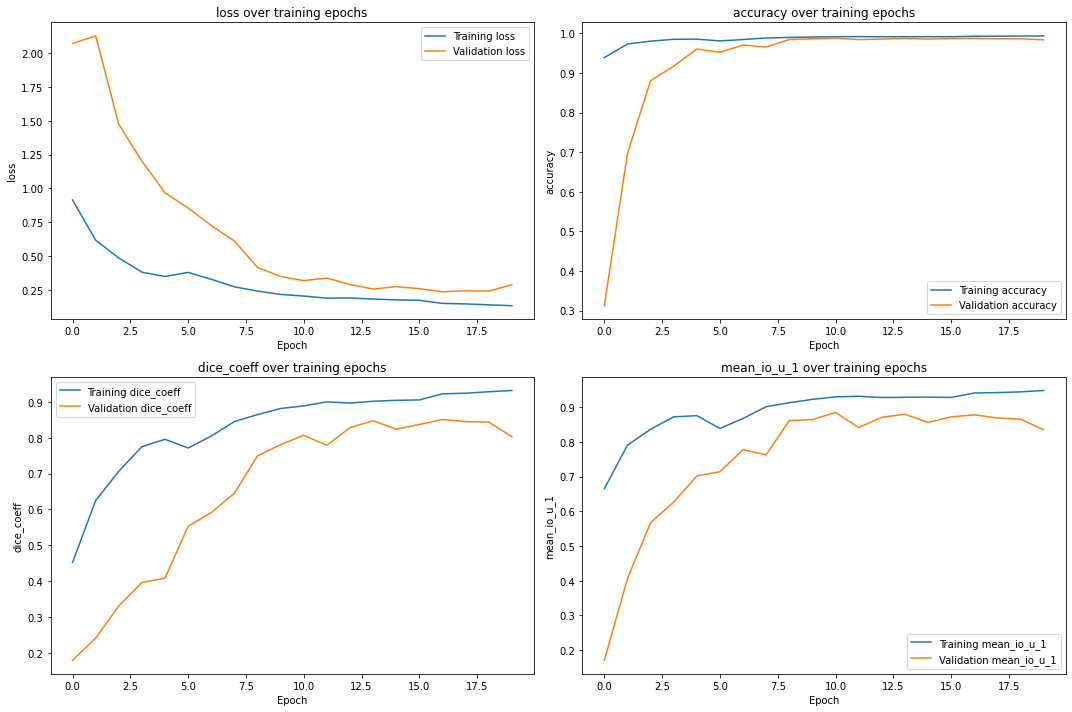

In [110]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'dice_coeff', 'mean_io_u_1']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.title(f'{metric} over training epochs')
    
    plt.tight_layout()
    plt.show()

plot_metrics(history)

**1. Loss over training epochs (왼쪽 상단)**
- 파란색(훈련 손실)과 주황색(검증 손실) 선이 모두 지속적으로 감소
- 초기에 검증 손실이 훈련 손실보다 훨씬 높았으나 점차 간격이 줄어듦
- 약 15 에폭 이후 두 손실 모두 안정화되는 경향

**2. Accuracy over training epochs (오른쪽 상단)**
- 훈련 정확도(파란색)가 초기에 빠르게 증가한 후 약 0.95 수준에서 안정화
- 검증 정확도(주황색)도 꾸준히 향상되어 약 0.93 수준에 도달
- 두 선이 가까워진 것은 모델이 과적합 없이 잘 일반화되고 있음을 의미

**3. Dice Coefficient over training epochs (왼쪽 하단)**
- 훈련 데이터에 대한 Dice 계수(파란색)가 약 0.9 이상으로 증가
- 검증 데이터에 대한 Dice 계수(주황색)도 약 0.8 이상까지 향상
- Dice 계수는 세그멘테이션의 질을 측정하는 중요한 지표로, 높은 값은 좋은 성능을 의미

**4. Mean IoU over training epochs (오른쪽 하단)**
- 훈련 데이터의 Mean IoU(파란색)가 약 0.9 수준까지 상승
- 검증 데이터의 Mean IoU(주황색)도 약 0.8 이상으로 향상
- 이는 모델이 용종의 위치와 경계를 정확하게 식별하고 있음을 보여줌

**종합 분석**:
- 모델 성능이 전체적으로 우수하며, 특히 검증 데이터에서의 IoU와 Dice 계수가 높음
- 훈련과 검증 지표 간의 간격이 적절하여 과적합이 크게 발생하지 않음
- VGG16 인코더 활용이 세그멘테이션 성능 향상에 효과적이었음
- 약 15-18 에폭에서 최적의 모델이 얻어졌을 것으로 보이며, 이후에는 성능 향상이 미미함

이 결과는 사전 학습된 VGG16 모델을 인코더로 활용한 접근법이 의료 이미지 세그멘테이션에 매우 효과적임을 보여줌

### 6-5. Evaluate the test dataset

In [112]:
test_loss, test_acc, test_dice, test_iou = vgg_unet.evaluate(
    test_dataset,
    steps=validation_steps
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test Mean IoU: {test_iou:.4f}")

7/7 [==============================] - 1s 183ms/step - loss: 0.2886 - accuracy: 0.9837 - dice_coeff: 0.8032 - mean_io_u_1: 0.8350
Test Loss: 0.2886
Test Accuracy: 0.9837
Test Dice Coefficient: 0.8032
Test Mean IoU: 0.8350


- **Test Loss: 0.2886** - 낮은 손실값으로, 모델이 예측을 잘 수행하고 있음을 나타냅니다.

- **Test Accuracy: 0.9837** - 매우 높은 정확도(98.37%)를 보이고 있습니다. 이는 대부분의 픽셀을 올바르게 분류했음을 의미합니다.

- **Test Dice Coefficient: 0.8032** - 0.8 이상의 Dice 계수는 의료 이미지 세그멘테이션에서 매우 좋은 성능으로 간주됩니다. 이는 예측된 세그멘테이션과 실제 세그멘테이션 간의 중첩이 높다는 것을 보여줍니다.

- **Test Mean IoU: 0.8350** - 0.83의 IoU는 뛰어난 세그멘테이션 품질을 나타냅니다. 이는 모델이 용종의 위치와 경계를 정확하게 식별함을 의미합니다.

종합적으로, VGG16을 인코더로 활용한 U-Net 모델은 위내시경 이미지에서 용종을 검출하는 데 매우 효과적인 성능을 보여주고 있습니다. 특히 83.5%의 Mean IoU는 임상적으로 유용한 수준의 세그멘테이션 정확도를 제공합니다. 이 결과는 전이학습의 이점을 잘 보여주며, 제한된 의료 데이터셋에서도 사전학습된 모델을 활용하여 높은 성능을 달성할 수 있음을 입증합니다.

In [118]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = vgg_unet(test_images, training=False)
        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title("Input image")
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

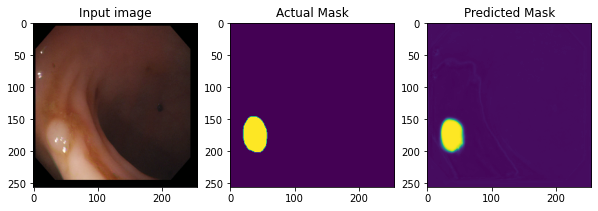

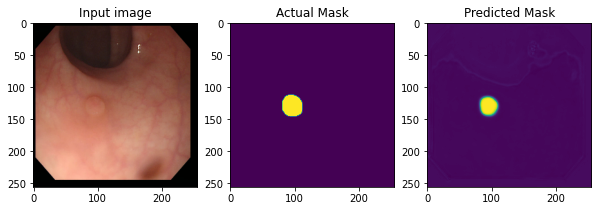

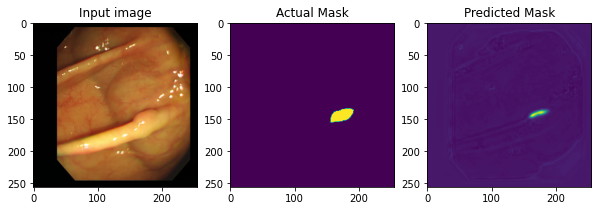

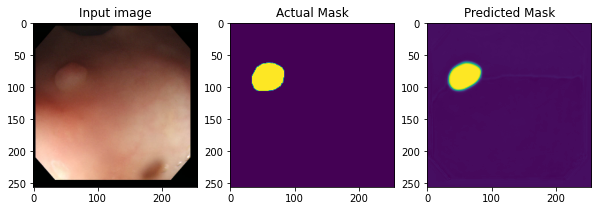

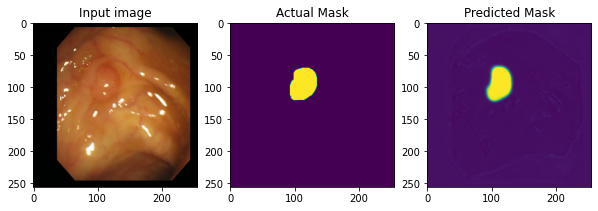

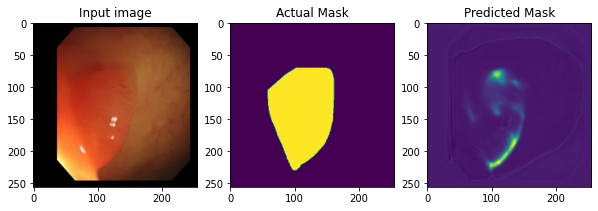

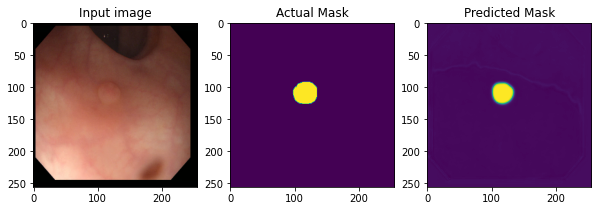

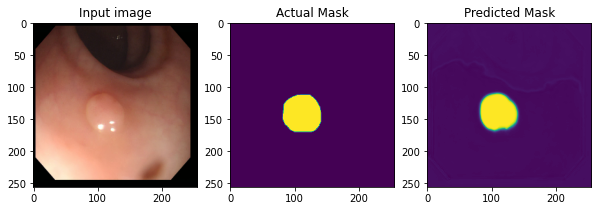

In [119]:
print_images()

- 1-2, 4-5, 7-8행: 모델이 작은 및 중간 크기의 용종을 매우 정확하게 세그멘테이션하고 있습니다. 위치, 크기, 형태가 실제 마스크와 거의 동일합니다.
- 3행: 위내시경 이미지의 긴 형태의 용종을 인식했으나, 약간 흐릿하고 색상이 옅게 예측되었습니다. 그러나 위치는 정확합니다.
- 6행: 가장 문제가 있는 케이스로, 큰 용종을 제대로 세그멘테이션하지 못하고 있습니다. 대신 이미지 가장자리에 잘못된 경계를 예측하고 있습니다. 이는 이 특정 형태나 위치의 용종에 대한 훈련 데이터가 부족했거나 이미지의 밝기, 대비 등의 특성이 모델에 혼란을 주었을 수 있습니다.
- 전반적으로, 모델은 한 가지 예외적인 케이스를 제외하고 대부분의 용종을 성공적으로 탐지하고 세그멘테이션하고 있습니다. 이는 VGG16 인코더를 사용한 전이학습이 효과적이었음을 보여줍니다. 그러나 일부 특정 형태나 크기의 용종에 대해서는 모델의 성능을 더 향상시킬 수 있는 여지가 있습니다.

---

## 7.위내시경 용종 검출을 위한 세그멘테이션 모델 비교 분석

### 7-1. 모델별 아키텍처 특징 및 구조적 복잡성

### 7-1-1. Encoder-Decoder 모델 (약 700만 파라미터)
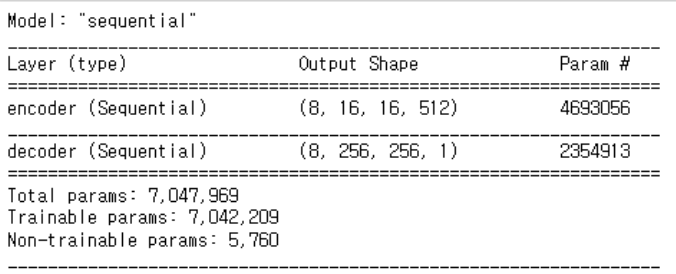
- **구조**: 순차적 다운샘플링(인코더)과 업샘플링(디코더) 구조
- **구현 방식**: Sequential API
- **특징**:
  - 인코더에서 추출된 정보가 디코더로 직접 전달되지 않음
  - 깊은 층으로 갈수록 공간적 정보 손실 발생
  - 단순하고 직관적인 구조로 구현 용이

### 7-2-2. U-Net 모델 (약 6,100만 파라미터)
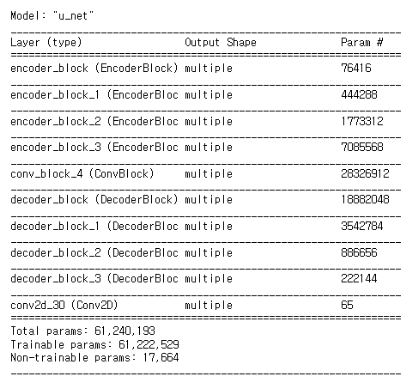
- **구조**: 대칭적 U자형 구조와 스킵 커넥션 구현
- **구현 방식**: 모델 서브클래싱
- **특징**:
  - 각 단계의 인코더 출력이 대응되는 디코더 단계로 직접 연결됨
  - 인코더에서 포착된 공간적/지역적 정보가 디코더에서 보존됨
  - 복잡한 구조이지만 의료 이미지 세그멘테이션에 최적화됨

### 7-2-3. VGG16 기반 U-Net 모델 (약 2,900만 파라미터)
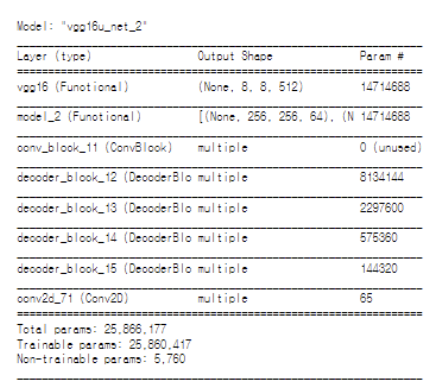
- **구조**: 사전 학습된 VGG16을 인코더로 활용한 U-Net
- **구현 방식**: 모델 서브클래싱 + 전이학습
- **특징**:
  - ImageNet으로 사전 학습된 가중치 활용
  - VGG16의 특정 층을 스킵 커넥션으로 활용
  - 학습 최적화를 위한 콜백 기능 활용 (조기 종료, 학습률 감소)

## 7-2. 성능 비교 및 평가

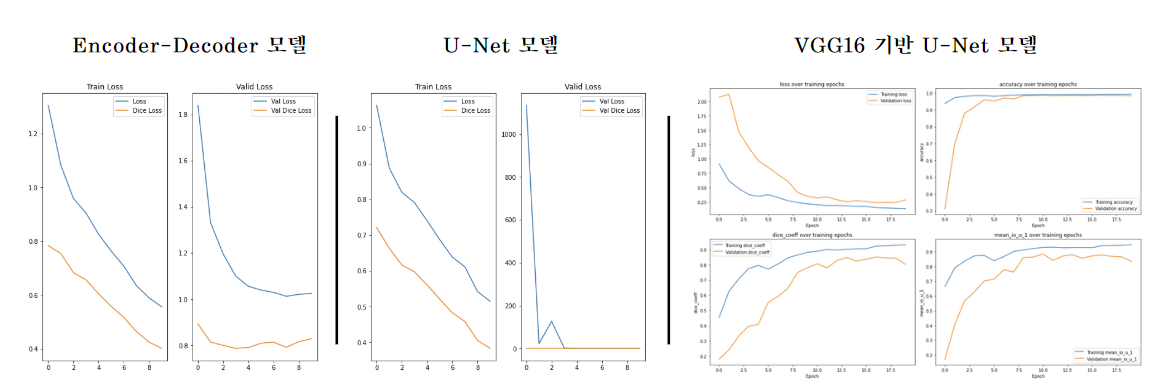

| 모델 | Mean IoU | 파라미터 수 | 학습 안정성 | 예측 특성 |
|------|----------|------------|------------|----------|
| Encoder-Decoder | 0.655 | 약 700만 | 후반부 과적합 경향 | 경계 구분 부정확, 넓은 활성화 영역 |
| U-Net | 0.929 | 약 6,100만 | 안정적 학습 패턴 | 정확한 경계 검출, 배경과 용종의 명확한 구분 |
| VGG16 기반 U-Net | 0.835 | 약 2,900만 | 안정적 학습 패턴 | 대부분 정확하나 복잡한 케이스에서 부분적 오류 |

### 7-3. 구조적 특징과 성능 관계 분석

### 7-3-1. 스킵 커넥션의 중요성
- **성능 순위**: U-Net(0.929) > VGG16 U-Net(0.835) > Encoder-Decoder(0.655)
- **분석**: 스킵 커넥션이 있는 두 U-Net 모델이 없는 Encoder-Decoder보다 크게 우수
- **원인**: 
  - 저수준 특징(경계, 텍스처)과 고수준 특징(의미론적 정보)의 효과적인 결합
  - 다운샘플링 과정에서 손실되는 공간적 정보의 보존
  - 그래디언트 소실 문제 완화로 더 효과적인 학습 가능

### 7-3-2. 모델 복잡성과 성능 관계
- **관찰**: 단순히 파라미터 수가 많다고 성능이 향상되는 것은 아님
- **분석**: 
  - U-Net이 가장 많은 파라미터(6,100만 개)로 최고 성능 달성
  - VGG16 U-Net은 더 적은 파라미터(2,900만 개)로도 준수한 성능 기록
  - 모델 아키텍처의 적합성이 단순한 복잡성보다 중요

### 7-3-3. 도메인 특화 vs 전이학습
- **관찰**: 순수 U-Net(0.929) > VGG16 U-Net(0.835)
- **분석**: 예상과 달리 순수 U-Net이 더 우수한 성능 기록
- **원인**:
  - 의료 이미지와 일반 이미지(ImageNet) 사이의 도메인 차이
  - 의료 도메인 특성에 맞게 처음부터 학습된 모델의 우수성
  - 사전 학습된 특징이 반드시 특수 도메인에 최적화되지 않음

### 7-3-4.학습 패턴 분석
- **Encoder-Decoder**: 검증 손실이 후반부에 증가하는 과적합 경향
- **U-Net**: 안정적인 학습 패턴, 검증 손실이 지속적으로 감소
- **VGG16 U-Net**: 초기에 빠른 수렴 후 안정적 학습 패턴 유지
- **분석**: 스킵 커넥션이 그래디언트 흐름을 개선하여 안정적인 학습 촉진

### 7-4. 시각적 결과 분석

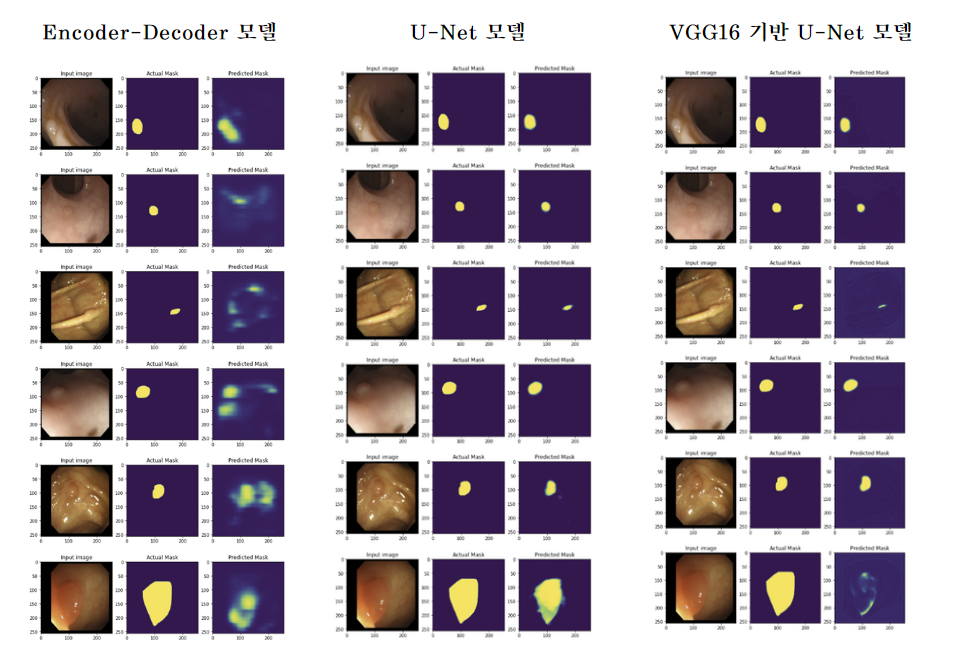

### 7-4-1. Encoder-Decoder
- 용종의 대략적 위치는 감지하지만 경계가 불분명함
- 실제 용종 영역보다 넓은 활성화 영역 발생
- 히트맵 형태의 출력으로 명확한 이진 분할이 어려움

### 7-4-2. U-Net
- 용종의 정확한 형태와 경계를 식별
- 배경과 용종 사이의 명확한 구분
- 이진 마스크에 가까운 선명한 예측 결과

### 7-4-3. VGG16 기반 U-Net
- 대부분의 용종을 정확하게 식별
- 일부 복잡한 형태의 용종에서 부분적 오류 발생
- 두 번째 케이스와 같은 큰 용종 영역에서 오분류 발생

## 8. 종합 결론 및 임상적 의의

### 아키텍처 선택의 중요성
- 의료 이미지 세그멘테이션에는 도메인 특화된 U-Net 구조가 최적
- 스킵 커넥션은 경계 검출이 중요한 의료 이미지 분석에 필수적 요소
- 전이학습이 항상 최선의 선택은 아니며, 도메인 특성을 고려한 설계가 중요

### 실용적 관점의 모델 선택
- **U-Net**: 높은 성능, 도메인 특화된 학습, 높은 계산 자원 요구
- **VGG16 U-Net**: 준수한 성능, 전이학습의 효율성, 중간 수준의 계산 자원
- **Encoder-Decoder**: 낮은 복잡성, 기본적인 성능, 적은 계산 자원

### 임상 적용 시 고려사항
- 고정밀 분할이 필요한 진단 목적에는 U-Net 적합
- 제한된 컴퓨팅 환경이나 실시간 처리가 필요한 경우 VGG16 U-Net 고려 가능
- 파라미터 수와 모델 크기는 실제 임상 환경에서의 배포 시 중요한 고려 요소

이 연구 결과는 의료 이미지와 같은 특수 도메인에서는 해당 도메인에 맞춤화된 아키텍처가 일반적인 컴퓨터 비전 모델보다 더 효과적일 수 있음을 보여줍니다. 또한 단순한 모델 복잡성보다는 목적에 맞는 아키텍처 설계가 성능에 더 큰 영향을 미친다는 중요한 시사점을 제공합니다.